In [2]:
import os                                        
import math                                       
import random                                     # random choices for sampling
import time                                       # measure elapsed time
import numpy as np                               
import matplotlib.pyplot as plt                  
import torch                                      # main PyTorch package
import torch.nn as nn                            
from torch.utils.data import Dataset, DataLoader  # dataset and dataloader utilities

print("numpy", np.__version__)                     # show numpy version
print("torch", torch.__version__)                  # show torch version
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

numpy 2.0.2
torch 2.8.0+cu126
Using device: cuda


In [3]:
file_path = "/kaggle/input/office-script-clean/office_script_clean.txt" 


with open(file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()                          


raw_text = raw_text.replace("\r\n", "\n").replace("\r", "\n") 


print("Loaded characters:", len(raw_text)) 


print(raw_text[:800])

Loaded characters: 3427466
Michael: All right Jim. Your quarterlies look very good. How are things at the library?
Jim: Oh, I told you. I couldn't close it. So...
Michael: So you've come to the master for guidance? Is this what you're saying, grasshopper?
Jim: Actually, you called me in here, but yeah.
Michael: All right. Well, let me show you how it's done.
Michael:  Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just wanted to talk to you manager-a-manger.  All right. Done deal. Thank you very much, sir. You're a gentleman and a scholar. Oh, I'm sorry. OK. I'm sorry. My mistake.  That was a woman I was talking to, so... She had a very low voice. Probably a smoker, so...  So that's the way it's done.
Michael: I've


In [4]:

vocab = sorted(list(set(raw_text))

stoi = {ch:i for i,ch in enumerate(vocab)}   
itos = {i:ch for i,ch in enumerate(vocab)}        


data_ids = np.array([stoi[ch] for ch in raw_text], dtype=np.int64)


vocab_size = len(vocab)                      
total_chars = len(raw_text)                      
context_length = 128                            


print("vocab size:", vocab_size)                
print("total characters:", total_chars)         
print("context length (suggested):", context_length) 

vocab size: 72
total characters: 3427466
context length (suggested): 128


In [5]:
# 90/10 train/validation split index
split_at = int(0.9 * len(data_ids))              

# split encoded ids into train and validation arrays
train_ids = data_ids[:split_at]                 
val_ids = data_ids[split_at:]                   

# sliding windows of characters
class CharDataset(Dataset):                        
    def __init__(self, arr, context_len):            # constructor with array and window size
        self.arr = arr                               # store array of ids
        self.context_len = context_len               # store context length
    def __len__(self):                               # required: number of samples
        return max(0, len(self.arr) - self.context_len)  # number of windows
    def __getitem__(self, idx):                      # required: get one sample by index
        x = self.arr[idx: idx + self.context_len]   # input window of length context_len
        y = self.arr[idx + 1: idx + 1 + self.context_len]  # target is next characters
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)  # return tensors

# instantiate datasets for train and validation
train_dataset = CharDataset(train_ids, context_length) 
val_dataset = CharDataset(val_ids, context_length)    

# dataloader parameters
batch_size = 64                                   
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=4,       
    pin_memory=True      
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=True,
    num_workers=4,
    pin_memory=True
)


print("Train batches per epoch:", len(train_loader))   # number of training batches
print("Val batches per epoch:", len(val_loader))       # number of validation batches


Train batches per epoch: 48196
Val batches per epoch: 5353


In [6]:

embed_size = 128                     # embedding vector size for each character

checkpoint_path = "lstm_modules_fast.pt"  # where checkpoints will be saved #lstm_modules_full
hidden_size = 256
n_layers = 1
context_length = 64
num_epochs = 15
learning_rate = 0.001

embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size).to(device)  # char -> vector

lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True).to(device)  # recurrent core

fc = nn.Linear(in_features=hidden_size, out_features=vocab_size).to(device)  # project LSTM outputs to vocab logits


params = list(embed.parameters()) + list(lstm.parameters()) + list(fc.parameters())  # gather all trainable params
optimizer = torch.optim.Adam(params, lr=learning_rate)  # Adam over all params
criterion = nn.CrossEntropyLoss()                        # loss: cross-entropy over vocab logits


print("Vocab size:", vocab_size)                          
print("Parameter count:", sum(p.numel() for p in params)) 
print("Train batches per epoch:", len(train_loader))      
print("Val batches per epoch:", len(val_loader))        

Vocab size: 72
Parameter count: 422984
Train batches per epoch: 48196
Val batches per epoch: 5353


In [7]:
def evaluate_modules(embed, lstm, fc, dataloader):
    #Compute average negative log-likelihood (NLL) and perplexity on dataloader.

    total_loss = 0.0  # loss * token_count
    total_tokens = 0          

    with torch.no_grad(): 
        for xb, yb in dataloader:    # mini-batches
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            emb = embed(xb)          # (B, T, E)
            out, _ = lstm(emb)       # (B, T, H)
            logits = fc(out)         # (B, T, V) logits 
            
            B, T, V = logits.shape   # batch, time, vocab sizes
            logits_flat = logits.view(B*T, V)     # flatten to (B*T, V) for loss
            targets_flat = yb.view(B*T)          # flatten targets to (B*T)

            loss = criterion(logits_flat, targets_flat)  # cross-entropy averaged over B*T
            total_loss += loss.item() * (B*T)            # weight by token count
            total_tokens += (B*T)                       # increase token counter

    avg_nll = total_loss / total_tokens        # average negative log-likelihood per token
    ppl = math.exp(avg_nll)                    # perplexity = exp(avg NLL)
    return avg_nll, ppl                        # return both values

In [8]:
def train_modules_with_history(embed, lstm, fc, train_loader, val_loader, num_epochs, save_path):
    """
    Train modules and print batch-level progress with ETA.
    Returns histories: train_losses, val_losses, train_ppls, val_ppls.
    """
    embed.to(device); lstm.to(device); fc.to(device)       

    train_losses = []                                      # avg train loss per epoch
    val_losses = []                                        # avg val loss per epoch
    train_ppls = []                                        # train perplexity per epoch
    val_ppls = []                                          # val perplexity per epoch

    total_batches = len(train_loader)                      # batches per epoch

    for epoch in range(num_epochs):                        # epoch loop
        embed.train(); lstm.train(); fc.train()            # training mode
        running_loss = 0.0                                 # loss accumulator
        running_tokens = 0                                 # token counter
        epoch_start = time.time()                          # epoch timer start

        for batch_idx, (xb, yb) in enumerate(train_loader, start=1):  
            xb = xb.to(device); yb = yb.to(device)         # move to device
            optimizer.zero_grad()                           # reset gradients

            emb_out = embed(xb)                             # embeddings
            lstm_out, _ = lstm(emb_out)                     # LSTM forward
            logits = fc(lstm_out)                           # project to vocab

            B, T, V = logits.shape                          # shapes
            logits_flat = logits.view(B*T, V)               
            targets_flat = yb.view(B*T)                     

            loss = criterion(logits_flat, targets_flat)     # compute loss
            loss.backward()                                 # backprop
            torch.nn.utils.clip_grad_norm_(params, 1.0)     # gradient clipping
            optimizer.step()                                # optimizer step

            running_loss += loss.item() * (B*T)             # accumulate weighted loss
            running_tokens += (B*T)                         # accumulate tokens

            # ---- progress reporting ----
            if batch_idx % 200 == 0 or batch_idx == total_batches:
                elapsed = time.time() - epoch_start        
                progress = batch_idx / total_batches        # fraction of epoch done
                eta = elapsed / progress - elapsed          # estimated remaining time
                avg_loss = running_loss / running_tokens    # running average loss

                print(
                    f"Epoch {epoch+1}/{num_epochs} | "
                    f"Batch {batch_idx}/{total_batches} "
                    f"({progress*100:5.1f}%) | "
                    f"loss {avg_loss:.4f} | "
                    f"elapsed {elapsed/60:.1f}m | "
                    f"ETA {eta/60:.1f}m"
                )


        train_loss, train_ppl = evaluate_modules(embed, lstm, fc, train_loader)
        val_loss, val_ppl = evaluate_modules(embed, lstm, fc, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ppls.append(train_ppl)
        val_ppls.append(val_ppl)

        print(
            f"Epoch {epoch+1} DONE | "
            f"train_loss {train_loss:.4f} ppl {train_ppl:.3f} | "
            f"val_loss {val_loss:.4f} ppl {val_ppl:.3f}"
        )

        # save checkpoint after each epoch
        torch.save({
            'embed_state': embed.state_dict(),
            'lstm_state': lstm.state_dict(),
            'fc_state': fc.state_dict(),
            'stoi': stoi,
            'itos': itos,
            'epoch': epoch + 1,
            'val_ppl': val_ppl
        }, save_path)

    return train_losses, val_losses, train_ppls, val_ppls

In [9]:
def generate_script(seed_text, temperature, num_tokens_to_generate):
    """
    Generate characters using saved LSTM modules if checkpoint exists.
    If no checkpoint found, fall back to bigram sampling built from training text.
    Signature required by the task: generate_script(seed_text, temperature, num_tokens_to_generate)
    """
    ckpt = checkpoint_path  # uses the same checkpoint path defined earlier

    if os.path.exists(ckpt):                           
        ck = torch.load(ckpt, map_location=device)     # load checkpoint to CPU/GPU as needed
        embed.load_state_dict(ck['embed_state'])       # restore embedding weights
        lstm.load_state_dict(ck['lstm_state'])         # restore LSTM weights
        fc.load_state_dict(ck['fc_state'])             # restore final linear weights
        embed.to(device); lstm.to(device); fc.to(device) 

        if len(seed_text) == 0:                         # if seed is empty, start with newline
            seed_text = "\n"

        # map seed chars to ids using global stoi (unknown -> 0)
        input_ids = [stoi.get(ch, 0) for ch in seed_text]
        inp = torch.tensor([input_ids], dtype=torch.long).to(device)  # shape (1, L)
        out_text = seed_text                              # initialize output string with seed

        with torch.no_grad():                             # disable gradients during sampling
            emb_seed = embed(inp)                         # embed the seed -> (1, L, E)
            out_seed, hidden = lstm(emb_seed)             # run entire seed to prime hidden state
            last_id = input_ids[-1]                       # start sampling conditioned on last seed id

            for _ in range(num_tokens_to_generate):       # generate requested number of characters
                step_inp = torch.tensor([[last_id]], dtype=torch.long).to(device)  # (1,1) tensor
                step_emb = embed(step_inp)                # embedding for the last token -> (1,1,E)
                #logits_step, hidden = lstm(step_emb, hidden)  # one-step forward using current hidden
                #logits_np = logits_step[0, -1, :].cpu().numpy()  # extract logits for vocabulary (V,)
                lstm_out, hidden = lstm(step_emb, hidden)
                logits_step = fc(lstm_out)                      #  project to vocab
                logits_np = logits_step[0, -1, :].cpu().numpy() # (vocab_size,)

                if temperature <= 0.0:
                    temperature = 1e-8

                logits_scaled = logits_np / temperature    # scale logits by 1/temperature
                exps = np.exp(logits_scaled - np.max(logits_scaled))  # subtract max for stability
                probs = exps / exps.sum()                 # normalized sampling probabilities

                next_id = np.random.choice(len(probs), p=probs)  # sample next char id
                next_char = itos[next_id]                   # convert id back to character
                out_text += next_char                       # append to generated output
                last_id = next_id                           # update last_id for next step

        return out_text                                   # return generated text from LSTM

    else:
        if 'bigram' not in globals():                    # if bigram not available, build it
            # build bigram from training portion of raw_text
            train_text = raw_text[:int(0.9 * len(raw_text))]    # same 90/10 split as before
            chars = sorted(list(set(train_text)))               # bigram vocab
            stoi_big = {ch:i for i,ch in enumerate(chars)}      # char->id for bigram
            itos_big = {i:ch for i,ch in enumerate(chars)}      # id->char for bigram
            V = len(chars)                                      # bigram vocab size
            counts = np.zeros((V, V), dtype=np.float64)        # bigram counts
            unigram = np.zeros(V, dtype=np.float64)            # unigram counts

            for a, b in zip(train_text, train_text[1:]):       # count consecutive pairs
                ai = stoi_big[a]; bi = stoi_big[b]
                counts[ai, bi] += 1.0
                unigram[ai] += 1.0
            unigram[stoi_big[train_text[-1]]] += 1.0           # last char count
            alpha = 1e-3
            bigram_probs = (counts + alpha) / (counts.sum(axis=1, keepdims=True) + alpha * V)  # row-normalize
            unigram_probs = (unigram + alpha) / (unigram.sum() + alpha * V)

            # store globally for reuse during this session
            bigram = {'chars': chars, 'stoi': stoi_big, 'itos': itos_big, 'bigram_probs': bigram_probs, 'unigram_probs': unigram_probs}

        # perform sampling from the bigram model with temperature
        if len(seed_text) == 0:
            seed_text = "\n"
        out_text = seed_text                                  # initialize with the seed
        last_char = seed_text[-1]                             # condition on last char of seed

        for _ in range(num_tokens_to_generate):               # generate requested chars
            if last_char in bigram['stoi']:                   # get conditional distribution
                probs = bigram['bigram_probs'][bigram['stoi'][last_char]].copy()
            else:
                probs = bigram['unigram_probs'].copy()       # fallback to unigram after unknown char

            if temperature <= 0.0:                            # guard temperature
                temperature = 1e-8

            logits = np.log(probs + 1e-12) / temperature      # apply temperature in log space
            exps = np.exp(logits - np.max(logits))            # numerical stability subtraction
            probs_t = exps / exps.sum()                       # normalized probabilities

            next_i = np.random.choice(np.arange(len(probs_t)), p=probs_t)  # sample char index
            next_c = bigram['itos'][next_i]                   # convert index to char
            out_text += next_c                                # append generated char
            last_char = next_c                                # update last_char for next step

        return out_text                                      # return bigram-generated text

In [10]:
num_epochs = 6   # enough to show training behavior

train_losses, val_losses, train_ppls, val_ppls = train_modules_with_history(
    embed,
    lstm,
    fc,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    save_path=checkpoint_path
)


Epoch 1/6 | Batch 200/48196 (  0.4%) | loss 2.2907 | elapsed 0.0m | ETA 11.4m
Epoch 1/6 | Batch 400/48196 (  0.8%) | loss 1.9898 | elapsed 0.1m | ETA 10.0m
Epoch 1/6 | Batch 600/48196 (  1.2%) | loss 1.8440 | elapsed 0.1m | ETA 9.6m
Epoch 1/6 | Batch 800/48196 (  1.7%) | loss 1.7534 | elapsed 0.2m | ETA 9.3m
Epoch 1/6 | Batch 1000/48196 (  2.1%) | loss 1.6897 | elapsed 0.2m | ETA 9.2m
Epoch 1/6 | Batch 1200/48196 (  2.5%) | loss 1.6420 | elapsed 0.2m | ETA 9.0m
Epoch 1/6 | Batch 1400/48196 (  2.9%) | loss 1.6032 | elapsed 0.3m | ETA 9.0m
Epoch 1/6 | Batch 1600/48196 (  3.3%) | loss 1.5715 | elapsed 0.3m | ETA 8.9m
Epoch 1/6 | Batch 1800/48196 (  3.7%) | loss 1.5451 | elapsed 0.3m | ETA 8.8m
Epoch 1/6 | Batch 2000/48196 (  4.1%) | loss 1.5221 | elapsed 0.4m | ETA 8.8m
Epoch 1/6 | Batch 2200/48196 (  4.6%) | loss 1.5023 | elapsed 0.4m | ETA 8.7m
Epoch 1/6 | Batch 2400/48196 (  5.0%) | loss 1.4848 | elapsed 0.5m | ETA 8.7m
Epoch 1/6 | Batch 2600/48196 (  5.4%) | loss 1.4692 | elapsed 0.5m

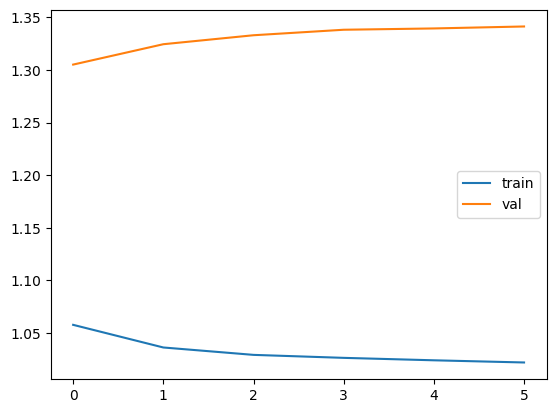

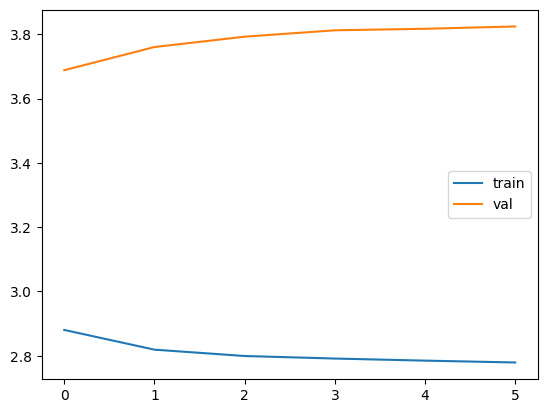

In [11]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

plt.plot(train_ppls, label="train")
plt.plot(val_ppls, label="val")
plt.legend()
plt.show()


In [12]:

print(generate_script("MICHAEL: ", temperature=0.7, num_tokens_to_generate=800))

MICHAEL: Huh... We've been candy for an artificant.
Darryl: And that's what I did, yeah.
Michael: Okay, I just came in and give you a picture of myself from you, but sometimes... I... I just want to come into his ST.. You know what? I like a little rating times.
Michael: You better be considering my respectful. And you don't think you're a history.
Michael: That is so cool.
David: What is going on?
Michael: I am just taking you in a note, Jim. Ryan.
Michael: I am a back these business, getting with a better man. They're mission sexy sentences.
Dwight: Watch the table.
Michael: Hmmm.
Michael: Excuse me, that's not about the break.
Dwight: Cookies. Here we go. 
Michael: Guys. Thanks.
Ryan: They are going to be shoops you don't know if you know all of you to flet the first time, and I know you did not


In [13]:
print(generate_script("MICHAEL: ", temperature=0.335, num_tokens_to_generate=800))

MICHAEL: YOU MADS. Oh, you know what? I'm gonna need to go to the hospital and we were the one thing. 
Michael:  Okay, now I can't take a little bit of a streamers. And the people who work out there will be so dorky.
Michael: Well, I was just watching a business coming to me. I am sorry about that. And I want you to see you and I am so many times.
Michael: Well, I don't know. I don't know. I just don't know.
Michael: Hey, what's the sale?
Michael: I don't know. I don't know. I don't know what you're doing this. The rest of the baby in the bathroom.
Jim: Okay.
Michael: That was a problem.
Pam: I don't know. I don't know what the best manager. The person can have a couple of things who doesn't show you this. I think I'm gonna make a couple of the first time. I was thinking that I want to give you thi


In [14]:

print(generate_script("MICHAEL: ", temperature=1, num_tokens_to_generate=800))

MICHAEL: No, no, no, no, no. It will.
Jan:  Nazili, what 's having baby? Watch oper a year.
Pam: GItare Flax. Though. Lets be telling me now of a Michael. After all about this. It's also not a long time, he can take the cat with - since I'm going to come in on you. Okay? Well, idiot. One Sabre plan.
Michael: And how does that make a Corner Man?
Pam: Oh.
Jim: Wow, I know you know what Dwight sitter talking with the news and precises are trying to have her.
Dwight: My job best work stickmet? 
Dwight: Thank you.
Michael: You're cool.
Michael: In three weird, like, affiry, about Paper Charles...Taper medami. After 25 miles after day how kind of look of sleep back to my life.
Michael: Yes it is!
Phyllis: I'm sorry  -- somebody's blindfouse man. It's over.
Michael:  Pam. Nice to meet...
Jim:  Hey, guys. 
